### First Load the data and prepare training and testing images

In [146]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import os


# a function which reads images from a directory
def read_images(dirpath = '../data/' ):
    X, y = [], []
    
    image_size = None
    for filename in os.listdir(dirpath):
        image_path = os.path.join(dirpath, filename)
        im = Image.open(image_path)
        im = im.convert('L')
        subject = filename.split('_')[0]
        image_size = np.asarray(im).shape
        X.append(np.asarray(im, dtype=np.uint8).reshape(1, -1))
        person,_ = subject.split(".")
        y.append(person)

    X = np.vstack(X)
    return  X, np.asarray(y), image_size


# Load the data
all_images, all_classes, (height, width) = read_images()

all_images = np.array(all_images)
all_classes = np.array(all_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_classes, test_size=0.1, random_state=40)
print(X_train.shape)
print(X_test.shape)
        
print(y_train.shape) 
print(y_test.shape)



(148, 77760)
(17, 77760)
(148,)
(17,)


### Reduce the dimensions using principal component analysis

In [148]:
# now reduce the dimension of the data using PCA
def pca(X, num_components):

    mu = X.mean(axis=0)
    X = X - mu
    C = np.dot(X, X.T)
    eigen_values, eigen_vectors = np.linalg.eigh(C)        

    eigen_vectors  = np.dot(X.T , eigen_vectors)

    # normalize the eigen vectors
    n = eigen_vectors.shape[1]
    for i in range(n):
        eigen_vectors[:, i] = eigen_vectors[:, i] / np.linalg.norm(eigen_vectors[:, i])
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]

    eigen_values, eigen_vectors = eigen_values[:num_components].copy() , eigen_vectors[:, :num_components].copy()

    return [eigen_values, eigen_vectors, mu]
classes = np.unique(y_train)


_, w, training_mean = pca(X_train,X_train.shape[0] - classes.shape[0])

# project x_train into the reduced dimension
x_train_projected = np.dot(X_train - training_mean, w)


### Find facespace from generalized matrix by using Linear Discriminant analysis (LDA)

In [197]:
# now claculate the Linear Discriminant Analysis (LDA)

# first calculate the total mean of the training images
total_mean = x_train_projected.mean(axis = 0)

dimensions = x_train_projected.shape[1]

# now calculate within class scatter matrix and between class scatter matrix sw and sb
sw = np.zeros((dimensions, dimensions))
sb = np.zeros((dimensions, dimensions))

for person in classes:
    Xi = x_train_projected[np.where(y_train == person)[0], :]
    current_mean = Xi.mean(axis=0)
    sw = sw + np.dot (( Xi - current_mean ).T , ( Xi - current_mean ))
    sb  = sb + dimensions * np.dot((total_mean - current_mean).T , total_mean - current_mean) 
# now find the generalized matrix to calculate generalized eigenvactors from
generalized_matrix = np.dot(np.linalg.inv(sw),sb)
eigen_values,eigen_vectors = np.linalg.eig(generalized_matrix)


# sort the eigenvalues and eigenvectors in descending order
idx = eigen_values.argsort()[::-1] # sort in descending order
eigenvalues = eigen_values[idx] # sorted eigenvalues
eigenvectors = eigen_vectors[:, idx] # sorted eigenvectors

eigenvectors = np.dot(w,eigenvectors)

# facespace =  np.dot(x_train_projected,eigenvectors.T)
facespace = eigenvectors.T


### Test using test images

In [198]:
def test(image_idx):
    # choose a threshold
    not_face_threshold = 100000
    num_of_chosen_eigenaces = 100
    test_image = X_test[image_idx] - training_mean

    # print("Reconstructed image vs Test Image:")
    omega = facespace[:num_of_chosen_eigenaces].dot(test_image) # projection of test image onto the face space
    reconstructed_image = facespace[:num_of_chosen_eigenaces].T.dot(omega) # reconstruction of the test image

    # calculate the euclidean distance between the test image and the reconstructed image
    euclidean_distance = np.linalg.norm(test_image - reconstructed_image)

    print("Euclidean distance between the test image and the reconstructed image:", euclidean_distance)
    if euclidean_distance < not_face_threshold:
        print("This is a face")
    else:
        print("This is not a face")


    unknown_face_threshold = 50000

    # find the image that is closest to the test image
    min_distance = float('inf')
    min_distance_index = -1

    for i in range(len(X_train)):
        omega_i = facespace[:num_of_chosen_eigenaces].dot(X_train[i]) # projection of train image onto the face space

        distance = np.linalg.norm(omega - omega_i) # euclidean distance between the projected test image and the projected train image
        
        if distance < min_distance:
            min_distance = distance
            min_distance_index = i
    print(min_distance_index,"the mean distance index")

    print("Euclidean distance between the test image and the closest image in the training set:", min_distance)

    if min_distance < unknown_face_threshold:
        print("This is a known face")
    else:
        print("This is not a known face")

    # plot the closest image
    plt.title("Closest image vs test image")
    
    plt.subplot(1, 2, 1)
    plt.title("queried image")
    plt.imshow((test_image + training_mean).reshape(height, width), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("predicted image")
    plt.imshow((X_train[min_distance_index] + training_mean).reshape(height, width), cmap='gray')
    plt.axis('off')
    plt.show()


Euclidean distance between the test image and the reconstructed image: 31043.95809335659
This is a face
37 the mean distance index
Euclidean distance between the test image and the closest image in the training set: 35696.16723399161
This is a known face


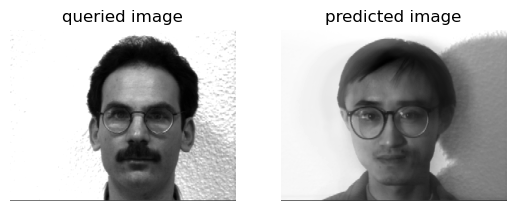

Euclidean distance between the test image and the reconstructed image: 42883.63178103764
This is a face
101 the mean distance index
Euclidean distance between the test image and the closest image in the training set: 34361.637848361715
This is a known face


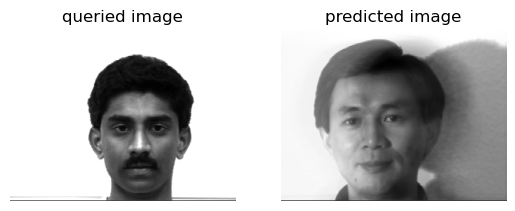

In [200]:
for i in range(2):
    test(i)